In [149]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [150]:
df = pd.read_csv('04-stock_price_prediction.csv')
df.head()

,Unnamed: 0,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [ ]:
# turn the first column into datetime type and set it as index
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'],dayfirst=False)
df.set_index('Date', inplace=True)

In [152]:
df.head()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
Date,,,,,
2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [ ]:
# only keep the first stock's prices
series= df['Stock_1'].values
print(series[:10])

[101.76405235 102.17126854 103.17125755 105.48321524 107.45317546
 106.40305934 107.41398249 107.25140368 107.14070001 107.58061812]


In [154]:
class StockDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
# this LSTM only has one direction
# class StockLSTM(nn.Module):
#     def __init__(self, input_size=1, hidden_size=256, num_layers=4, output_size=1,dropout_prob=0.2):
#         super(StockLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
#                             dropout=dropout_prob if num_layers > 1 else 0)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)
#         out = self.fc(out[:, -1, :])  # Use the last time step
#         return out

class StockBiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, output_size=1, dropout_prob=0.2):
        super(StockBiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                              batch_first=True, 
                              dropout=dropout_prob if num_layers > 1 else 0,
                              bidirectional=True) # open bidirectional
        #because it is bidirectional, so hidden_size * 2
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [156]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()

In [157]:
seq_length = 10
dataset = StockDataset(series_scaled, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

model = StockBiLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(x_batch.unsqueeze(-1))  # Add feature dimension
        y_batch = y_batch.unsqueeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/100], Loss: 0.1936
Epoch [10/100], Loss: 0.1455
Epoch [15/100], Loss: 0.0972
Epoch [20/100], Loss: 0.0253
Epoch [25/100], Loss: 0.0082
Epoch [30/100], Loss: 0.0084
Epoch [35/100], Loss: 0.0033
Epoch [40/100], Loss: 0.0033
Epoch [45/100], Loss: 0.0014
Epoch [50/100], Loss: 0.0010
Epoch [55/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0000
Epoch [65/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0002
Epoch [75/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0003
Epoch [85/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0003
Epoch [95/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0002


In [158]:
model.eval()
test_inputs = torch.tensor(series_scaled[-seq_length:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # (1, seq_length, 1)

test_inputs.shape

torch.Size([1, 10, 1])

In [159]:
preds = []
for _ in range(50):  # Predict 50 steps ahead
    with torch.no_grad():
        pred = model(test_inputs)           
        preds.append(pred.item())
        print(f'Predicted: {pred.item()}')
      
        inputs_without_oldest = test_inputs[:, 1:, :]
        new_timestep = pred.unsqueeze(-1) 
        test_inputs = torch.cat((inputs_without_oldest, new_timestep), dim=1)


Predicted: 0.07047277688980103
Predicted: 0.07399064302444458
Predicted: 0.077975794672966
Predicted: 0.08182858675718307
Predicted: 0.08553571999073029
Predicted: 0.08877430856227875
Predicted: 0.09161505103111267
Predicted: 0.0943346843123436
Predicted: 0.09666422009468079
Predicted: 0.09887079149484634
Predicted: 0.10107474029064178
Predicted: 0.10332044214010239
Predicted: 0.10545717179775238
Predicted: 0.10748739540576935
Predicted: 0.10942050069570541
Predicted: 0.1112646535038948
Predicted: 0.1130300909280777
Predicted: 0.11472439765930176
Predicted: 0.11635121703147888
Predicted: 0.11791659146547318
Predicted: 0.11942286789417267
Predicted: 0.12087120115756989
Predicted: 0.12226275354623795
Predicted: 0.1236005499958992
Predicted: 0.12488745152950287
Predicted: 0.12612596154212952
Predicted: 0.1273183673620224
Predicted: 0.12846672534942627
Predicted: 0.12957295775413513
Predicted: 0.13063886761665344
Predicted: 0.1316661536693573
Predicted: 0.13265639543533325
Predicted: 0.133

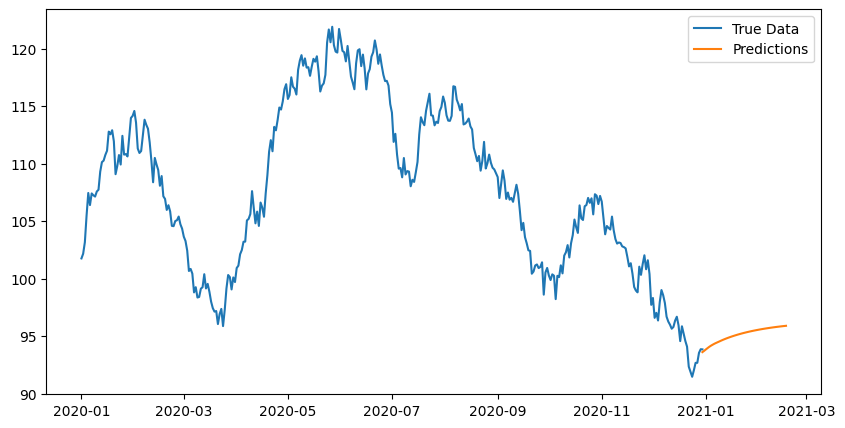

In [ ]:
# inverse transform the predictions
preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

plt.figure(figsize=(10,5))
plt.plot(df.index, series, label="True Data")
plt.plot(pd.date_range(df.index[-1], periods=50, freq="D"), preds, label="Predictions")
plt.legend()
plt.show()